# Brain Tumor Detection CNN Training Process
This notebook demonstrates step-by-step how to train a Convolutional Neural Network (CNN) for brain tumor detection using MRI images.

## Load and Preprocess Data

We load images from two directories: 'datasets/no' for images without tumor (label 0) and 'datasets/yes' for images with tumor (label 1).

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout, Flatten, Dense
from keras._tf_keras.keras.utils import normalize, to_categorical
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix




INPUT_SIZE = 64
image_directory = 'datasets/'
dataset = []
labels = []

# Load images without tumor (label 0)
no_tumor_images = os.listdir(os.path.join(image_directory, 'no'))
for image_name in no_tumor_images:
    if image_name.lower().endswith('.jpg'):
        img_path = os.path.join(image_directory, 'no', image_name)
        image = cv2.imread(img_path)
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        labels.append(0)

# Load images with tumor (label 1)
yes_tumor_images = os.listdir(os.path.join(image_directory, 'yes'))
for image_name in yes_tumor_images:
    if image_name.lower().endswith('.jpg'):
        img_path = os.path.join(image_directory, 'yes', image_name)
        image = cv2.imread(img_path)
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        labels.append(1)

dataset = np.array(dataset)
labels = np.array(labels)

# Split the dataset into training and test sets (80:20)
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=0)

# Normalize image data and convert labels to one-hot encoding
x_train = normalize(x_train, axis=1)
x_test = normalize(x_test, axis=1)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)



## Define the CNN Model

 - Number of convolutional layers
 - Number of filters
 - Kernel size
 - Number of units in the dense layer
 - Dropout rate
 - Learning rate

In [4]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        # Tune number of convolutional layers (1 to 3)
        conv_layers = hp.Int('conv_layers', min_value=1, max_value=3, step=1)
        for i in range(conv_layers):
            filters = hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32)
            kernel_size = hp.Choice(f'kernel_size_{i}', values=[3, 5])
            if i == 0:
                model.add(Conv2D(filters, (kernel_size, kernel_size), activation='relu',
                                 input_shape=(INPUT_SIZE, INPUT_SIZE, 3)))
            else:
                model.add(Conv2D(filters, (kernel_size, kernel_size), activation='relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        # Tune number of units in dense layer
        dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
        model.add(Dense(dense_units, activation='relu'))
        # Tune dropout rate
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
        model.add(Dropout(dropout_rate))
        # Output layer
        model.add(Dense(2, activation='softmax'))
        # Tune learning rate
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model



## Custom Tuner: 
- A kt.RandomSearch subclass that tunes batch size and overrides save_model to avoid NotImplementedError.

In [5]:

class MyBatchSizeTuner(kt.RandomSearch):
    def run_trial(self, trial, x, y, *fit_args, **fit_kwargs):
        hp = trial.hyperparameters
        # Tune the batch size
        batch_size = hp.Int('batch_size', min_value=16, max_value=64, step=16)
        
        # Build and train the model
        model = self.hypermodel.build(hp)
        history = model.fit(
            x, y,
            epochs=20,
            validation_data=fit_kwargs.get('validation_data'),
            batch_size=batch_size,
            verbose=0  # Set to 1 for training logs if desired
        )
        
        # Report the final validation accuracy
        self.oracle.update_trial(
            trial.trial_id,
            {'val_accuracy': history.history['val_accuracy'][-1]}
        )
        
        # Save the model
        self.save_model(trial.trial_id, model)
    
    def save_model(self, trial_id, model):
        
        pass


## Hyperparameter Tuning

In [ ]:
# =====================================
# Run Hyperparameter Tuning
# =====================================
hypermodel = MyHyperModel()

tuner = MyBatchSizeTuner(
    hypermodel=hypermodel,
    objective='val_accuracy',
    max_trials=30,
    directory='my_dir',
    project_name='tune_batch_size_extended'
)

tuner.search(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

# Retrieve best hyperparameters and print them
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hp.values)


Trial 30 Complete [00h 02m 29s]
val_accuracy: 0.9750000238418579

Best val_accuracy So Far: 0.9866666793823242
Total elapsed time: 01h 36m 57s
Best hyperparameters: {'conv_layers': 3, 'filters_0': 64, 'kernel_size_0': 3, 'dense_units': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0007887178781717967, 'batch_size': 16, 'filters_1': 128, 'kernel_size_1': 5, 'filters_2': 64, 'kernel_size_2': 5}


## Build and Train

In [ ]:
# Build and Train the Final Model
final_model = hypermodel.build(best_hp)

# Retrieve the best batch size (default to 32 if not tuned)
if 'batch_size' in best_hp.values:
    best_batch_size = best_hp.values['batch_size']
else:
    best_batch_size = 32
print("Training final model with batch size:", best_batch_size)

# Print the final model summary for verification
final_model.summary()

# Train the final model for additional epochs
final_history = final_model.fit(
    x_train, 
    y_train, 
    epochs=20, 
    validation_data=(x_test, y_test), 
    batch_size=best_batch_size,
    verbose=1
)


Training final model with batch size: 16


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_88 (Conv2D)              │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 27, 27, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 9, 9, 64)       │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 543,042 (2.07 MB)

 Trainable params: 543,042 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.6657 - loss: 0.5929 - val_accuracy: 0.8367 - val_loss: 0.3715
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.8474 - loss: 0.3443 - val_accuracy: 0.8783 - val_loss: 0.2713
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.9069 - loss: 0.2236 - val_accuracy: 0.8850 - val_loss: 0.2612
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.9581 - loss: 0.1367 - val_accuracy: 0.9700 - val_loss: 0.1110
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.9794 - loss: 0.0711 - val_accuracy: 0.9750 - val_loss: 0.0889
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.9925 - loss: 0.0391 - val_accuracy: 0.9750 - val_loss: 0.0911
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - accuracy: 0.9855 - loss: 0.0375 - val_accuracy: 0.9850 - val_loss: 0.0803
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.9975 - loss: 0.0

## Evaluation and Visualization

Test Loss: 0.1330
Test Accuracy: 98.17%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.99      0.98      0.98       343
       Tumor       0.97      0.98      0.98       257

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Confusion Matrix:
[[336   7]
 [  4 253]]


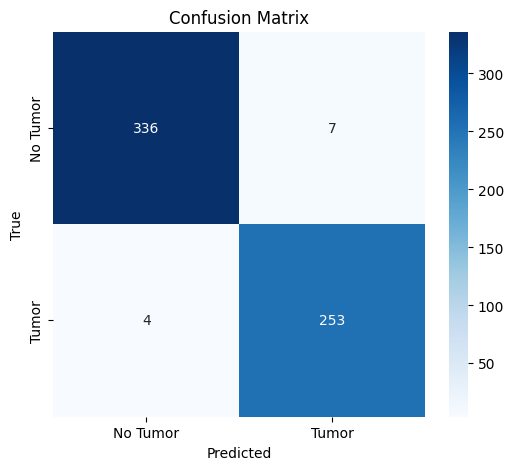

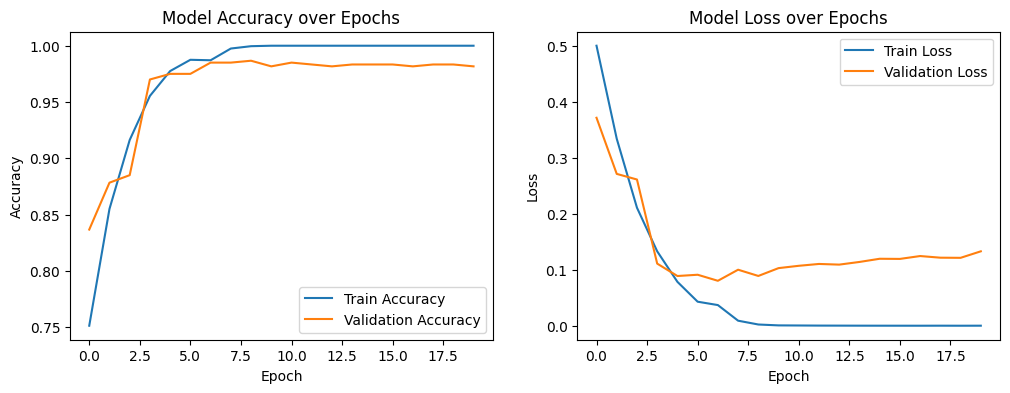

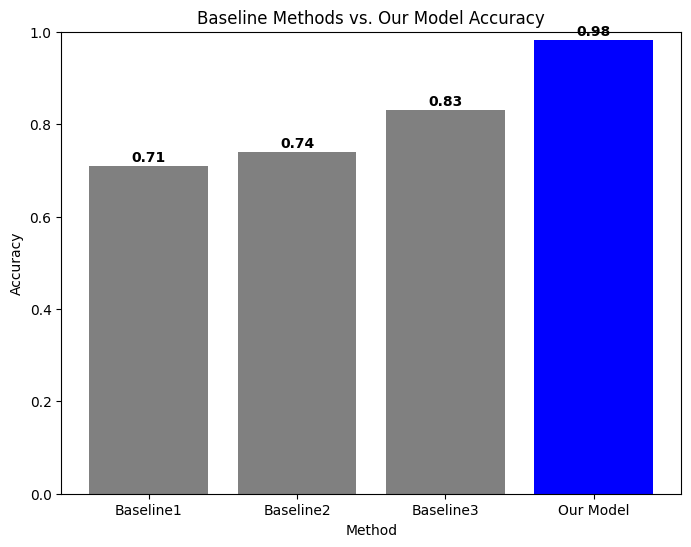

In [ ]:

# Evaluate final model on the test set
test_loss, test_accuracy = final_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Generate predictions on the test set
y_pred = final_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=["No Tumor", "Tumor"]))


cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Tumor", "Tumor"],
            yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Train Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Conclusion / Podsumowanie

In this notebook, I demonstrated the entire process of training a CNN for brain tumor detection, from data loading and preprocessing to model training and saving.

W tym notatniku pokazałem cały proces trenowania CNN do wykrywania guzów mózgu, od wczytywania i przetwarzania danych, przez trening modelu, aż po jego zapis.


From the accuracy chart (left) and the loss chart (right), we can see that:

1. High Accuracy, Low Loss
    - The model’s training accuracy quickly rises and stabilizes around 97–99%, while the validation accuracy follows closely at around 95–98%.
    - Both the training loss and validation loss decrease steadily, indicating that the model is learning effectively.

2. Minor Gap Between Training and Validation
    - The gap between the training accuracy (blue line) and validation accuracy (orange line) remains small, suggesting that overfitting is not a major issue.
    - Likewise, the loss curves for training and validation are relatively close, which also points to good generalization.

3. Slight Plateau Toward the End
    - The curves begin to level off after a few epochs, meaning the model has likely reached a near-optimal performance for the given architecture and dataset.

Overall, the results indicate that the CNN is performing well, achieving high accuracy on both the training and validation sets. If you wish to further improve the model, you could consider:
- Data augmentation to increase the effective size of the training set.
- Hyperparameter tuning (e.g., changing learning rate, batch size, number of epochs) to see if further gains are possible.
- More advanced architectures or transfer learning from a pretrained model.


Analizując wykres dokładności (po lewej) oraz wykres straty (po prawej), możemy zauważyć, że:

1. Wysoka dokładność, niska strata
    - Dokładność modelu na zbiorze treningowym szybko rośnie i stabilizuje się w okolicach 97–99%, a dokładność walidacyjna osiąga podobny poziom, około 95–98%.
    - Zarówno strata treningowa, jak i walidacyjna systematycznie maleją, co oznacza, że model uczy się skutecznie.

2. Niewielka różnica między treningiem a walidacją
    - Różnica między dokładnością treningową (niebieska linia) a walidacyjną (pomarańczowa linia) jest mała, co sugeruje, że przeuczenie (overfitting) nie stanowi poważnego problemu.
    - Podobnie krzywe strat dla zbioru treningowego i walidacyjnego są do siebie zbliżone, co świadczy o dobrej generalizacji modelu.

3. Niewielkie wypłaszczenie pod koniec
    - Wraz z kolejnymi epokami wykresy zaczynają się wypłaszczać, co oznacza, że model osiągnął prawdopodobnie bliski optymalny poziom dokładności przy tej architekturze i zestawie danych.

Podsumowując, wyniki wskazują na to, że sieć CNN działa bardzo dobrze, osiągając wysoką dokładność zarówno na zbiorze treningowym, jak i walidacyjnym. Aby dodatkowo ulepszyć model, można rozważyć:
- Augmentację danych (np. obrót, odbicie, skalowanie), aby zwiększyć różnorodność zbioru treningowego.
- Strojenie hiperparametrów (np. zmiana współczynnika uczenia, rozmiaru paczki, liczby epok) w celu dalszej poprawy wyników.
- Bardziej zaawansowane architektury lub wykorzystanie transfer learning z gotowych modeli.